In [102]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import os
import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

def construct_paths(name, log_num):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

#     with open(buffer_path,'rb') as f:
#         buffer = pickle.load(f)
    return model_path

def load_agent(name, lognumber=0):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(f"Logs available: {logs}")
    model_path = construct_paths(name, lognumber)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    return agent

In [103]:
agent = load_agent('4ActionsSplines50K', 0)
agent_contsr = load_agent('4ActionsSplines50KConstrained', 0)

Logs available: ['20201119-090233']
[INFO] [2021-02-04 12:41:22,458] [C:\Projects\credit_collections_rl\learning\resources\models\4ActionsSplines50K\20201119-090233] - Instantiated class DQNAgent
[WARNING] [2021-02-04 12:41:22,654] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-04 12:41:22,664] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Logs available: ['20201126-004420']
[INFO] [2021-02-04 12:41:22,671] [C:\Projects\credit_collections_rl\learning\resources\models\4ActionsSplines50KConstrained\20201126-004420] - Instantiated class DQNAgent
[WARNING] [2021-02-04 12:41:22,841] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-04 12:41:22,858] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled

price a policy

In [14]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    
#     w_normalized = np.linspace(0, 1, w_points)
#     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
#     wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    space_iterator = product(l, w)
    space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
    predictions = agent.main_net.predict_on_batch(space_product)
    z = np.amax(predictions, axis=1).reshape(l_points, w_points)
    p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent)
ww, ll, pc, zc = create_map(agent_contsr)

Text(0.5, 1.0, 'Simplest default with labels')

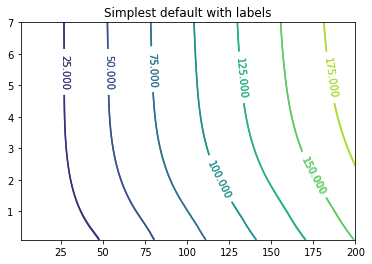

In [15]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
CS2 = ax.contour(ww, ll, zc)
ax.clabel(CS, inline=1, fontsize=10)
ax.clabel(CS2, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


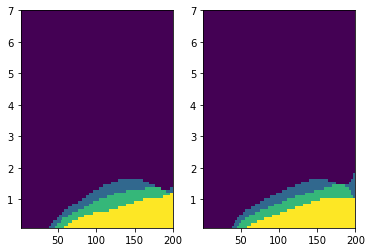

In [21]:
fig, ax = plt.subplots(ncols=2)
ax[0].pcolor(ww, ll, p)
ax[1].pcolor(ww, ll, pc)
# fig.colorbar()
# ax[0].show()

In [6]:
agent.env.observation(np.array([0.1, 0.1]))

array([1.00000000e-01, 9.92518734e-01, 9.89743889e-01, 2.77355092e-03,
       1.29464416e-06, 1.34257817e-10, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.45101269e-03, 2.08799098e-05,
       9.74636990e-09, 1.01072278e-12, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.33450686e-06, 2.61580096e-08,
       1.22100928e-11, 1.26621698e-15, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.59688604e-09, 7.27723176e-12,
       3.39688214e-15, 3.52265120e-19, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [7]:
agent.main_net.predict_on_batch(agent.env.observation(np.array([0.1, 0.1]))[None, :])

array([[ -0.25219956,  -2.3167553 ,  -5.3898244 , -10.549348  ]],
      dtype=float32)

In [10]:
np.argmax(agent.main_net.predict_on_batch(agent.env.observation(np.array([0.1, 100]))[None, :]))

3

In [63]:
agent.env.randomize_start = False
agent.env.env.randomize_start = False
agent.env.current_state

array([2.77546672, 5.62290742])

In [64]:
agent.env.current_state

array([2.77546672, 5.62290742])

In [66]:
agent.env.env.reset(tostate=np.array([1., 100]))

array([23.5523656 , 94.80357266])

In [68]:
agent.env.randomize_start

False

In [69]:
agent.env.randomize_start

False

In [70]:
type(agent.env.reset)

method

In [67]:
agent.env.reset(tostate=np.array([1., 100]))

array([9.01528506e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.26589205e-03,
       4.93087569e-02, 7.65667193e-02, 6.52645465e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.30011594e-03,
       2.06448984e-01, 3.20574324e-01, 2.73253681e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.90104798e-03,
       1.13001001e-01, 1.75468142e-01, 1.49566924e-02, 0.00000000e+00,
      

In [82]:
agent.env.step(0)

(array([8.68549554e+00, 6.27009578e-01, 0.00000000e+00, 9.83581214e-03,
        2.55633942e-01, 3.38669725e-01, 2.28700987e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.39767092e-03,
        1.40286117e-01, 1.85854274e-01, 1.25505921e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.45555493e-04,
        1.15800409e-02, 1.53415045e-02, 1.03599966e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.82251623e-06,
        2.03308139e-04, 2.69347298e-04, 1.81888100e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [88]:
agent.env.current_state

array([  0.94698116, 104.67886983])

In [92]:
agent.env.step(0)

(array([8.62557912e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.94679502e-02, 1.05991333e-02,
        8.68648628e-04, 1.51459897e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.28225994e-01, 1.78699402e-01,
        1.46452531e-02, 2.55358548e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.72996719e-01, 1.48630368e-01,
        1.21809550e-02, 2.12390387e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.30442215e-03, 4.52126065e-03,
        3.70538491e-04, 6.46080817e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [87]:
agent.env.reset()

array([9.46981164e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.57206169e-03, 3.46695211e-03,
       3.20438573e-04, 6.26790470e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.40022836e-01, 1.49342869e-01,
       1.38032526e-02, 2.69997058e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.26059935e-01, 2.02875389e-01,
       1.87510811e-02, 3.66778531e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.32873093e-02, 1.44894279e-02,
       1.33920846e-03, 2.61954449e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      